# Deep-Learning: Ziffernerkennung mit KNN (Tiefe Netze)
Nachdem wir im letzten Kapitel lediglich einziges Hidden Layer verwendet haben, erweitern wir dies nun auf sogenannte tiefe Netze, welche beliebig viele Hidden Layer enthalten können. Dieses Notebook ist sehr ähnlich zu dem aus dem letzten Kapitel, aber du kannst hier nun solche **tiefe Netze mit beliebig vielen Hidden Layern** erzeugen.

In [1]:
# Die notwendigen Bibliotheken werden geladen
import numpy as np
from scipy.special import expit as sigmoid
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

## Kantengewichte zufällig erzeugen

<div style="padding: 5px; border: 5px solid #0077b6;">

### Aufgabe 1

Finde heraus, was der untenstehende Befehl tut. Du kannst dafür mit den 3 Eingabewerten etwas herum experimentieren. Halte deine Beobachtungen schriftlich fest.

In [2]:
np.random.normal(0.0, 0.1, (2, 3))

array([[ 0.10711969,  0.22556148, -0.05877255],
       [-0.05093554, -0.03850708,  0.011028  ]])

Beobachtungen bitte hierher

#### Lösung
Es wird eine (2x3)-Matrix erzeugt. Die Einträge der Matrix werden mit normalverteilten Zufallswerten mit Mittelwert 0 und Standardabweichung 0.1 belegt.


## KNN als Klasse definieren
Zunächst definieren wir eine Python-Klasse für unser künstliches neuronales Netz. Die Funktionen `__init__` und `knn_output` kannst du sicherlich schon im Detail verstehen.

Die Funktion `train` wird zum Trainieren des KNN mittels Gradientenabstiegsverfahren verwendet. Die genaue Formulierung des Gradientenabstiegsverfahrens mit einer beliebigen Anzahl an Hidden-Layer-Neuronen ist etwas technischer und wird erst im nächsten Kapitel ausführlicher behandelt. Im Prinzip ist es aber genau dasselbe wie der weiter oben betrachtete Gradientenabstieg beim Beispiel mit den ungefährlichen und gefährlichen Tieren, nur halt mit sehr vielen Neuronen gleichzeitig.

<div style="padding: 5px; border: 5px solid #0077b6;">

### Aufgabe 2

Beschreibe, was die beiden Funktionen `__init__` und `knn_output` tun. Liste auf, welche Parameter sie erhalten und was sie zurückgeben.

Ergebnisse bitte hierher

#### Lösung
**\_\_init\_\_:** Konstruktor

- sizes: Die Größe der Input-, der versteckten und der Output-Schichten als Liste. Die Länge len(sizes) gibt die Anzahl der Schichten an.
- sizes[0] muss gleich 784 sein, nämlich die Anzahl der künstlichen Neuronen in der Input-Schicht, hier $28\cdot 28 = 784$
- sizes[-1] muss gleich 10 sein, nämlich die Anzahl an Neuronen am Ausgang, hier 10 (Ziffern 0 bis 9)
- learningrate: Die Lernrates für den Gradientenabstieg
- self.weights Liste von Propagationsmatrizen zwischen den einzelnen Layern
- self biases: Liste von Bias-Vektoren der einzelnen Layers

**knn_output:** Berechnung der Aktivierung am Ausgang durch Forward-Propagation
- inputs_list: Das Bild am Eingang als 784 reelle Zahlenwerte (28x28 Pixel-Graustufenbild)
- Die Funktion knn_output berechnet die Ausgangsaktivierung sukzessive durch Matrix-Vektormultiplikation mit anschließender komponentenweiser Anwendung der Aktivierungsfunktion.


In [3]:
# Klassendefinition des Neuronalen Netzes
class neuralNetwork:
    # Initialisierung des Neuronalen Netzes
    def __init__(self, sizes, learningrate):
 
        # Gewichtsmatrizen udn Biasvektoren initialisieren
        self.weights = [np.random.normal(0.0, pow(x, -0.5), (y, x)) for x, y in zip(sizes[:-1], sizes[1:])]
        self.biases  = [np.random.normal(0.0, pow(y,-0.5 ), (y, 1)) for y in sizes[1:]]
 
        # Lernrate
        self.lr = learningrate
 
        # Definition der Aktivierungsfunktion (hier als Sigmoid-Funktion)
        self.activation_function = lambda x: sigmoid(x)
 
        pass

    # Output des Künstlichen Neuronalen Netzes
    # NB: alle arrays sind stehende Vektoren!
    def knn_output(self, inputs_list):
        
        # Inputs in Array konvertieren 
        activation = np.array(inputs_list, ndmin=2).T # stehender Vektor

        # Berechnung der Aktivierung der Neuronen
        for w,b in zip(self.weights, self.biases):
            activation = np.dot(w, activation) + b
            activation = self.activation_function(activation)

        return activation
    

    # Gewichte des Neuronalen Netzes aktualisieren
    # siehe auch 
    # https://www.geeksforgeeks.org/backpropagation-in-machine-learning/
    def train(self, inputs_list, targets_list):

        # Inputs in 2-dimensionales Array konvertieren (Inputwerte und Zielwerte)
        inputs  = np.array(inputs_list, ndmin=2).T   # stehender Vektor
        targets = np.array(targets_list, ndmin=2).T # stehender Vektor
        
        activation = inputs
        activations = [inputs]
        zs=[]

        # Feedforward, abspeichern aller zs und activations, layer by layer
        for w,b in zip(self.weights, self.biases):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = self.activation_function(z)
            activations.append(activation)

        # Berechnung Fehler und Delta, zunächst Outputlayer
        errors = []
        deltas = []
        errors.insert(0, activations[-1]-targets )
        deltas.insert(0, errors[0] * activations[-1] * (1.0 - activations[-1]))

        # Berechnung der Fehler in den versteckten Schichten (Backpropagation)
        for i in range( 1, len(self.weights) ):
            #errors.insert(0, np.dot(self.weights[-i].T, errors[0]) ) #Version Yannik(?!)
            errors.insert(0, np.dot(self.weights[-i].T, deltas[0]) ) # Version Ulla
            deltas.insert(0, errors[0] * activations[-i-1] * (1.0 - activations[-i-1]))

        # Update der Kantengewichte mit Hilfe der Ableitung 
        # NB: activations[-3].T ist liegender Vektor!
        # activations[-2].T ist liegender Vektor!
        # NB: Hadamard-Produkte von stehenden Vektoren, Ergebnis ist ein stehender Vektor:
        #     (errors[-1] * activations[-1] * (1.0 - activations[-1])
        # NB: stehender mal liegender Vektor, Ergebnis ist Matrix:
        #    np.dot((errors[-1] * activations[-1] * (1.0 - activations[-1])), activations[-2].T)
        for i in range(1, len(self.weights)+1):
            self.weights[-i] -= self.lr * np.dot( deltas[-i], activations[-i-1].T )
            self.biases[-i]  -= self.lr * deltas[-i]

        pass

    
    

## Festlegen der Parameter und Erstellen des KNN

In [ ]:
# Anzahl der Neuronen in den einzelnen Schichten
# 28x28 = 784 Pixel-Bild als Input
#         100 künstl. Neuronen im ersten Hidden Layer
#          50 künstl. Neuronen im ersten Hidden Layer
#          10 Ziffern (0-9) als Output
sizes = [784,100,50,10]

#Lernrate
learning_rate = 0.1

# Neuronales Netz erstellen
knn = neuralNetwork(sizes, learning_rate)

## Trainingsdaten einlesen

In [5]:
# Einlesen der Trainingsdaten
training_data_file = open("mnist_dataset/mnist_train_1000.csv", 'r')
training_data_lines = training_data_file.readlines()
training_data_file.close()

## Funktionen zum Plotten der Bilder

In [6]:
# data_line ist eine Zeile aus dem Datensatz,
# also ein String der Länge 1+28x28 = 1+784 = 785
def plot(data_line):
    pic_values = data_line.split(',')
    image= np.asarray(pic_values[1:], dtype=float).reshape((28,28))
    fig, axes = plt.subplots(figsize=(1,1))
    axes.matshow(image, cmap=plt.cm.binary)
    axes.set_xticks([])
    axes.set_yticks([])
    plt.show()

In [7]:
# data_lines ist eine Liste von Zeilen aus dem Datensatz,
# also eine Liste von Strings der Länge 1+28x28 = 1+784 = 785
def plot_list(data_lines):
    images=[]
    for i in range(len(data_lines)):
        pics_values = data_lines[i].split(',')
        images.append(np.asarray(pics_values[1:], dtype=float).reshape((28,28)))
    fig, axes = plt.subplots(nrows=1, ncols=len(images))
    for j, ax in enumerate(axes):
        ax.matshow(images[j].reshape(28,28), cmap = plt.cm.binary)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

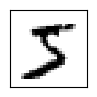

In [8]:
plot(training_data_lines[0])

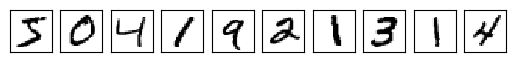

In [9]:
plot_list(training_data_lines[0:10])

## Funktionen zur Vorhersage der Ziffern

In [10]:
# Vorhersage für einzelnes Bild
def predict( pic):
    #Inputdaten vorbereiten
    pic_values = pic.split(',')
    inputs = (np.asarray(pic_values[1:], dtype=float) / 255.0 * 0.99) 

    # Auswertung durch Neuronales Netz
    outputs = knn.knn_output(inputs)

    # Index mit dem höchsten Gewicht in der Ausgangsschicht sagt Ziffer vorher
    return np.argmax(outputs)

In [11]:
# Vorhersage für Lite von Bildern
def predict_list( pics ):
    predictions = []
    for pic in pics:
        #Inputdat   en vorbereiten
        pic_values = pic.split(',')
        # Inputdaten standardisieren
        inputs = (np.asarray(pic_values[1:], dtype=float) / 255.0 * 0.99) + 0.01

        # Auswertung durch Neuronales Netz
        outputs = knn.knn_output(inputs)

        # Index mit dem höchsten Gewicht in der Ausgangsschicht sagt Ziffer vorher
        predictions.append(int(np.argmax(outputs)))
    return predictions

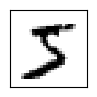

3


In [12]:
plot(training_data_lines[0])
print(predict(training_data_lines[0]))

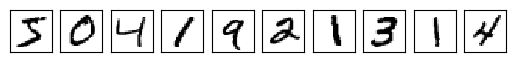

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [13]:
plot_list(training_data_lines[0:10])
print(predict_list(training_data_lines[0:10]))

## Neuronales Netz vor dem Training Testen

In [14]:
# Liste falsch klassifizierte Bilder erzeugen
def wrong_list(data_list):
    wrong_list = []
    for i in range(len(data_list)):
        prediction = predict(data_list[i])
        if prediction != int(data_list[i].split(',')[0]):
            wrong_list.append(data_list[i])
    return wrong_list

In [15]:
wl = wrong_list(training_data_lines)
len(wrong_list(training_data_lines))

908

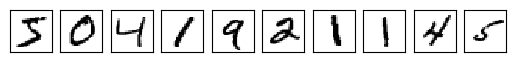

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[5, 0, 4, 1, 9, 2, 1, 1, 4, 5]


In [16]:
plot_list(wl[0:10])
print( predict_list(wl[0:10]) )
print( [int(wl[i].split(',')[0]) for i in range(len(wl[0:10]))] )

In [17]:
# Liste von falsch klassifizierte Bilder erzeugen
wl = wrong_list(training_data_lines)
print("Falsch klassifiziert:", len(wl))
print("Korrekt klassifiziert:", len(training_data_lines)-len(wl))
print("Anteil korrekt klassifiziert:", round((len(training_data_lines)-len(wl))/len(training_data_lines)*100,2), "%")

Falsch klassifiziert: 908
Korrekt klassifiziert: 91
Anteil korrekt klassifiziert: 9.11 %


<div style="padding: 5px; border: 5px solid #0077b6;">

### Aufgabe 3
Halte fest, was du beim Testen des KNN feststellst. Erkläre, warum das KNN die beobachtete Erkenntungsrate zeigt.


Ergebnisse bitte hier notieren.

#### Lösung
Die Vorhersage des KNN ist bisher noch völlig erratisch. Beim erneuten Erzeugen einer neuen Instanz der Klasse neuralNetwork können sich die Vorhersagen ändern.

Das KNN "rät" also einfach nur zufällig eine Vorhersage. Die Vorhersage für ein einzelnes Bild ist dann mit einer Wahrscheinlichkeit von $10\%$ korrekt. Der Erwartungswert für die Anzahl an Treffern bei 1000 Vorhersagen beträgt also $1000\cdot 10\% = 100$.

Der Grund für dieses Verhalten ist, dass wir die Gewichte und Biases mit Zufallswerten initialisiert haben und das KNN bisher auch noch nicht trainiert haben.

## Das KNN trainieren

<div style="padding: 5px; border: 5px solid #0077b6;">

### Aufgabe 4
Stelle Vermutungen an, warum es in dem folgenden Trainingsprozess sinnvoll ist, die Input-Daten vor der Verarbeitung zu standardisieren.

Vermutungen bitte hierher

#### Lösung:
Die Startwerte für die Gewichte und Biases wurden weiter oben mit normalverteilten Zufallswerten mit dem Mittelwert Null initialisiert. Ohne Standardisierung auf den Bereich $[0,1]$ der Input-Daten würden diese nicht zu den initialen Gewichts- und Biaswerten passen. 

(Anmerkungen: Im Beipiel zu dem gefährlichen/ungefährlichen Tieren weiter oben waren die Input-Daten nicht standardisiert. Das war dort der Grund dafür, dass die Gewichte des Hidden-Layer so klein im Vergleich zu denen des Output-Layers waren. In tatsächlichen Anwendungen wie hier in der Ziffernerkennung möchte man das gerne vermeiden.)

Der Grund für die weitere Einschränkung der Inputdaten auf den Bereich $[0.01,0.99]$ besteht darin, dass ansonsten die Gewichte in Laufe des Triningsprozesses immer größer werden würden, da die Werte 0 und 1 lediglich die asymptostischen Grenzwerte der Sigmoid-Funktion sind, aber durch dies niemals angenommen werden können. Im Gegensatz dazu können die Randwerte $0.01$ und $0.99$ durch die Sigmafunktion angenommen werden, wodurch die Konvergenz gegen stabile Werte für die Gewichte möglich wird.


In [36]:
# Anzahl der Epochen
epochs = 5

# Schleife über die Epochenanzahl
for e in range(epochs):
    
    # nacheinander alle Einträge des Trainingsdatensatzes durchgehen
    for x in training_data_lines:
        #Einträge anhand des Komma splitten
        pic_values = x.split(',')
        
        #Inputs standardisieren
        inputs = (np.asarray(pic_values[1:], dtype=float) / 255.0 * 0.99) + 0.01
        
        # Ergebnisvektor erstellen
        targets = np.zeros(sizes[-1]) + 0.01
        # Nur der richtige Wert wird auf 0.99 gesetzt
        targets[int(pic_values[0])] = 0.99
        
        knn.train(inputs, targets)

In [37]:
# Liste von falsch klassifizierte Bilder erzeugen
wl = wrong_list(training_data_lines)
print("Falsch klassifiziert:", len(wl))
print("Korrekt klassifiziert:", len(training_data_lines)-len(wl))
print("Anteil korrekt klassifiziert:", round((len(training_data_lines)-len(wl))/len(training_data_lines)*100,2), "%")

Falsch klassifiziert: 18
Korrekt klassifiziert: 981
Anteil korrekt klassifiziert: 98.2 %


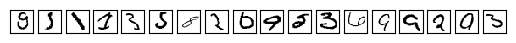

[0, 9, 5, 7, 5, 1, 5, 1, 0, 4, 2, 2, 0, 7, 7, 7, 0, 2]
[9, 5, 1, 1, 3, 5, 8, 2, 6, 9, 5, 3, 6, 9, 9, 2, 9, 3]


In [38]:
# False klassifizierte Bilder anzeigen
plot_list(wl)
print( predict_list(wl) )
print( [int(wl[i].split(',')[0]) for i in range(len(wl))] )

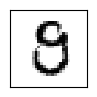

Prediction: 0
Classification 9


In [39]:
# Einzelnes falsch klassifiziertes Bild anzeigen
number=0
data_lines = training_data_lines
plot(wrong_list(data_lines)[number])
print("Prediction:", predict(wrong_list(data_lines)[number]))
print("Classification", wrong_list(data_lines)[number].split(',')[0])

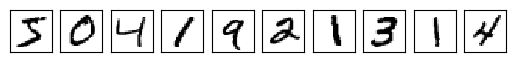

[5, 0, 4, 1, 9, 2, 1, 3, 1, 4]

In [40]:
# Vorhersage für Lite von Bildern anzeigen
plot_list(training_data_lines[0:10])
predict_list(training_data_lines[0:10])

<div style="padding: 5px; border: 5px solid #0077b6;">

### Aufgabe 5
Führe mehrere Trainingsepochen durch und beobachte, wie sich der Anteil an korrekt klassifizierten Bilder ändert. Halte deine Beobachtungen schriftlich fest.

Ergebnisse bitte hierher

#### Lösung

Für ein Netz mit 784-50-10 künstlichen Neuronen beispielhaft:

Bereits nach einem Training mit 5 Epochen hat sich die vorher erratische Erkennungsrate deutlich erhöht.

Weiteres Training erhöht die Erkennungsrate, aber die "Konvergenzrate" nimmt immer weiter ab. Als typische Werte für die Anzahl an korrekt erkannten Bilder ergibt sich bei den 1000 Trainingsbildern  in etwa:

|Anzahl Epochen|Anzahl korrekt erkannter Bilder|
|--------------|-------------------------------|
|  5           |    900                        |
| 10           |    950                        |
| 15           |    960                        |
| 20           |    965                        |

## Das KNN mit den Testdaten testen
Nun wollen wir schauen, ob das fertig trainierte KNN auch mit neuen Bildern zurecht kommt, die es im Laufe des Trainings noch niemals "gesehen" hat.

Dazu lesen wir zunächst die neuen Test-Daten aus einer Datei ein.

In [41]:
# Einlesen der Testdaten
test_data_file = open("mnist_dataset/mnist_test_100.csv", 'r')
test_data_lines = test_data_file.readlines()
test_data_file.close()

In [42]:
# Liste von korrekt klassifizierte Bilder erzeugen
correct_list = []
for i in range(len(test_data_lines)):
    prediction = predict(test_data_lines[i])
    if prediction == int(test_data_lines[i].split(',')[0]):
        correct_list.append(test_data_lines[i])

In [43]:
print( "Anzahl korrekt klassifiziert:", len(correct_list) )
print( "Anteil korrekt klassifiziert:", round(len(correct_list)/len(test_data_lines)*100,2) , "%" )

Anzahl korrekt klassifiziert: 86
Anteil korrekt klassifiziert: 86.87 %


In [44]:
# Liste falsch klassifizierte Bilder erzeugen
wrong_list = []
for i in range(len(test_data_lines)):
    prediction = predict(test_data_lines[i])
    if prediction != int(test_data_lines[i].split(',')[0]):
        wrong_list.append(test_data_lines[i])

Anzahl falsch klassifiziert: 13


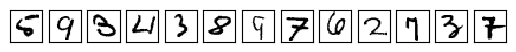

[6, 7, 4, 6, 5, 5, 4, 3, 2, 7, 9, 5, 3]

In [ ]:
print("Anzahl falsch klassifiziert:", len(wrong_list))
plot_list(wrong_list)
print(predict_list(wrong_list))

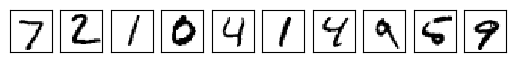

[7, 2, 1, 0, 4, 1, 4, 9, 6, 9]


In [46]:
# predictions anzeigen
for i in range(1):
    plot_list(test_data_lines[i*10:(i+1)*10])
    print( predict_list(test_data_lines[i*10:(i+1)*10]))

<div style="padding: 5px; border: 5px solid #0077b6;">

### Aufgabe 6
Teste, wie gut das KNN auf den unbekannten Testdaten abschneidet. Stelle Vermutungen über die Grenzen unseres bisherigen Modells an.

Ergebnisse bitte hierher

#### Lösung:
Das KNN erkennt einen recht hohen Anteil an Testdaten. Also liefert das Trainingsverfahren grundsätzlich schon einmal sinnvolle Ergebnisse.

Allerdings gibt es auch Fehlklassifizierungen, die sich auch schlecht durch weiteres Training mit den Trainingsdaten beheben lassen. Der Grund hierfür ist die geringe Anzahl an Trainingsdaten. Wir haben zwar mit 1.000 Bildern trainiert und mit 100 unbekannten getestet, was für uns als Menschen vielleicht erst einmal als große Zahlen erscheinen mag. In realen Anwendungen werden allerdings deutlich größere Datensätze verwendet.

Der Versuch, auf unserer relativ kleinen Anzahl an Trainingsdaten weiter zu trainieren und/oder die Anzahl an hidden Layern inklusive der Neuronenanzahl massiv zu erhöhen, sorgt nur für so genanntes *overfitting*. Dh. wir schaffen es zwar eventuell, noch einen größeren Anteil an Trainingsdaten korrekt zu erkennen. Aber bei den unbekannten Testdaten wird das Verfahren dadurch nicht notwendigerweise wesentlich besser.

Im Folgenden werden wir daher auch noch den kompletten MNIST-Datensatz mit 70.000 Datensätzen betrachten, um das Training zu verbessern.